In [3]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [4]:
train_images = glob.glob("Image/*")


In [5]:
train_images[:10]

['Image\\pexels.png']

In [6]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

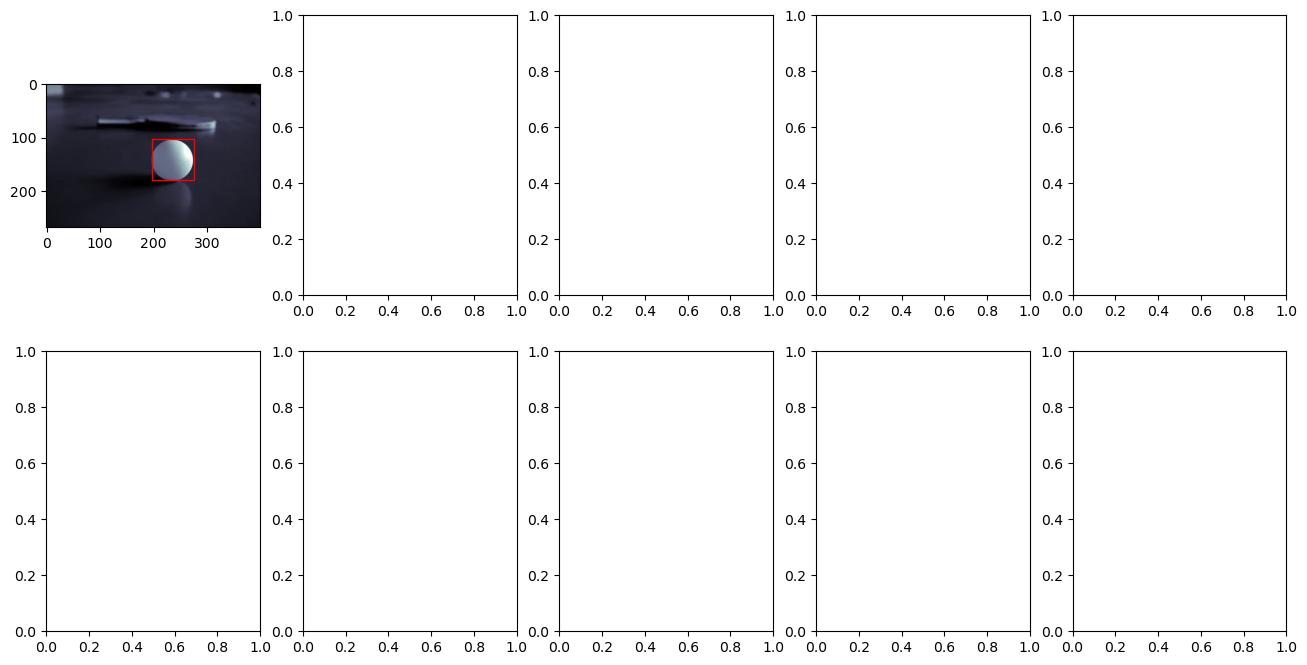

In [7]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
images = []
for img_path, ax in zip(train_images[:10], axs):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    img_cropped = img[y:y+h, x:x+w]
    images.append(img_cropped)
    ax.imshow(img, cmap="bone")

plt.savefig("rectangles.png")
plt.show()

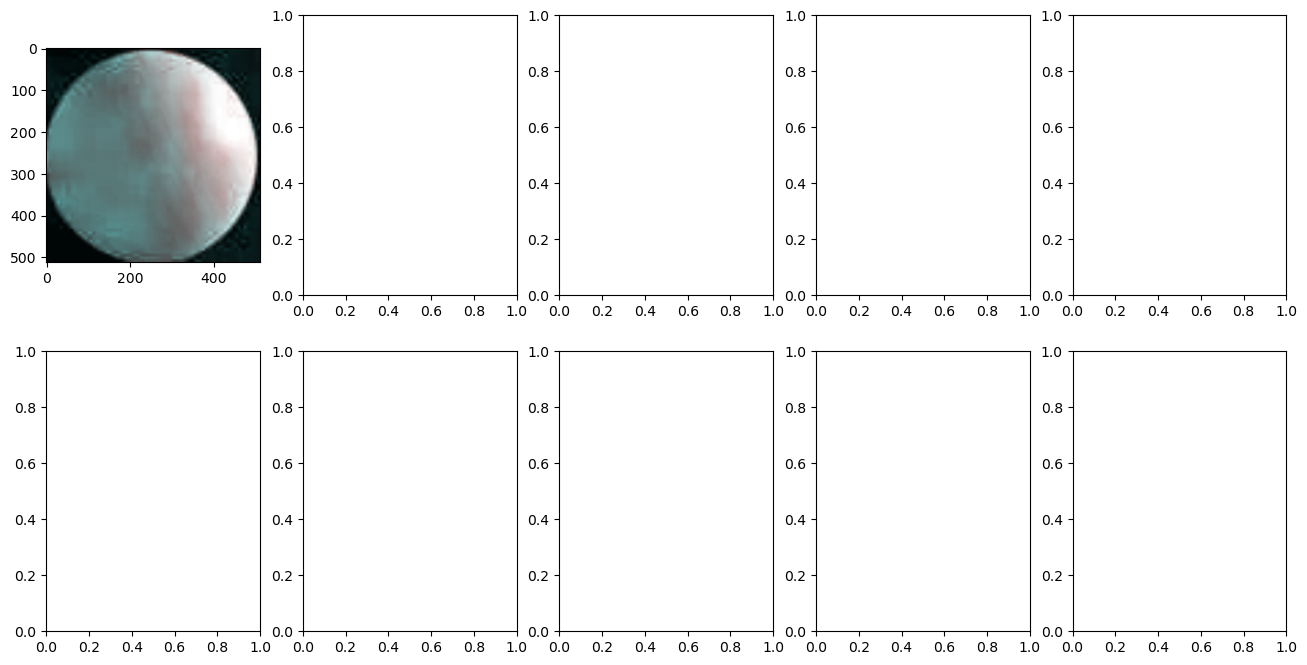

In [8]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
final_imgs = []
IMG_SIZE = 512
for img_cropped, ax in zip(images, axs):
    img_normalized = truncation_normalization(img_cropped)
    # Enhancing the contrast of the image.
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
    # Resize the image to the final shape. 
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
    ax.imshow(img_final)
    
plt.savefig("final_imgs.png")
plt.show()